<a href="https://colab.research.google.com/github/naoutix/mushroom_network/blob/main/test_mushroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, optimizers, regularizers, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Flatten, Dropout, concatenate
import pandas as pd
import tensorflow as tf
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
!git clone https://github.com/ddahon/mushroom-neural-network.git
path = "./mushroom-neural-network/data/"

fatal: destination path 'mushroom-neural-network' already exists and is not an empty directory.


In [ ]:
import os
import shutil

mushrooms_names= ["agaricus-bisporus",
                  "amanita-muscaria",
                  "boletus-edulis",
                  "cantharellus-cibarius",
                  "entoloma-sinuatum",
                  "lactarius-deliciosus",
                  "lycoperdon-perlatum",
                  "macrolepiota-procera",
                  "morchella-esculenta",
                  "rubroboletus-satanas"]
image_size = 150
length_train = 0
nb_agents = 5

#Images d'entrainement
train_filenames= []
for name in mushrooms_names:
  list_filenames = os.listdir(path + "train/" + name)
  train_filenames.append(list_filenames)
  length_train += len(list_filenames)

if not os.path.exists(path + "train/train"):
  os.mkdir(path + "train/train")
for j in range(nb_agents):
  if not os.path.exists(path + "train/train"+str(j)):
    os.mkdir(path + "train/train"+str(j))

path_train = path + "train/"
j=0
for i in range(10):
  for filename in train_filenames[i]:
    img = Image.open(path_train+mushrooms_names[i]+"/"+filename).convert('RGB')
    img = img.resize((image_size, image_size))
    img.save(path_train+"train/"+filename)
    img.save(path_train+"train"+str(j%nb_agents)+"/"+filename)
    img.save(path_train+"train"+str(i//2)+"/"+filename)
    j+=1

train_filenames = os.listdir(path + "train/train")
train_categories=[]
for filename in train_filenames:
  category = filename.split('_')[0]
  train_categories.append(mushrooms_names.index(category))

train_agents_filenames = []
train_agents_categories = []
for j in range(nb_agents):
  train_agents_filenames.append(os.listdir(path + "train/train"+str(j)))
  train_agent_j_categories = []
  for filename in train_agents_filenames[j]:
    category = filename.split('_')[0]
    train_agent_j_categories.append(mushrooms_names.index(category))
  train_agents_categories.append(train_agent_j_categories)

#Images de validation
validation_filenames= []
for name in mushrooms_names:
  validation_filenames.append(os.listdir(path + "validation/" + name))

if not os.path.exists(path + "validation/validation"):
  os.mkdir(path + "validation/validation")

path_validation = path + "validation/"
for i in range(10):
  for filename in validation_filenames[i]:
    img = Image.open(path_validation+mushrooms_names[i]+"/"+filename).convert('RGB')
    img = img.resize((image_size, image_size))
    img.save(path_validation+"validation/"+filename)

validation_filenames = os.listdir(path + "validation/validation")
validation_categories=[]
for filename in validation_filenames:
    category = filename.split('_')[0]
    validation_categories.append(mushrooms_names.index(category))

#Images de test
test_filenames= []
for name in mushrooms_names:
  test_filenames.append(os.listdir(path + "test/" + name))

if not os.path.exists(path + "test/test"):
  os.mkdir(path + "test/test")

path_test = path + "test/"
for i in range(10):
  for filename in test_filenames[i]:
    img = Image.open(path_test+mushrooms_names[i]+"/"+filename).convert('RGB')
    img = img.resize((image_size, image_size))
    img.save(path_test+"test/"+filename)

test_filenames = os.listdir(path + "test/test")
test_categories=[]
for filename in test_filenames:
    category = filename.split('_')[0]
    test_categories.append(mushrooms_names.index(category))

In [ ]:
#Images d'entrainement
train_df = pd.DataFrame({
    'filename': train_filenames,
    'category': train_categories
})

train_agents_df = []
for j in range(nb_agents):
  train_agents_df.append(
    pd.DataFrame({
      'filename': train_agents_filenames[j],
      'category': train_agents_categories[j]
    })
  )


#Images de validation
validation_df = pd.DataFrame({
    'filename': validation_filenames,
    'category': validation_categories
})


#Images de test
test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})


train_df['category'] = train_df['category'].astype(str)
for j in range(nb_agents):
  train_agents_df[j]['category'] = train_agents_df[j]['category'].astype(str)

validation_df['category'] = validation_df['category'].astype(str)
test_df['category'] = test_df['category'].astype(str)

total_train = train_df.shape[0]
total_validate = validation_df.shape[0]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16


#Images d'entrainement
train_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path + "train/train/",
    x_col='filename',
    y_col='category',
    target_size=(image_size,image_size),
    class_mode='categorical',
    batch_size=batch_size
)

train_agents_generator = []
for j in range(nb_agents):
  train_agents_generator.append(
    train_datagen.flow_from_dataframe(
      train_agents_df[j], 
      path + "train/train"+str(j)+"/",
      x_col='filename',
      y_col='category',
      target_size=(image_size,image_size),
      class_mode='categorical',
      batch_size=batch_size
    )
  )

#Images de validation
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    path + "validation/validation", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

#Images de test
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    path + "test/test", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    shuffle = False,
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


In [ ]:
train_datagen_2 = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator_augmented = train_datagen_2.flow_from_dataframe(
    train_df, 
    path + 'train/train/',
    x_col='filename',
    y_col='category',
    target_size=(image_size,image_size),
    class_mode='categorical',
    batch_size=batch_size
)

train_agents_generator_augmented = []
for j in range(nb_agents):
  train_agents_generator_augmented.append(
    train_datagen_2.flow_from_dataframe(
      train_agents_df[j], 
      path + "train/train"+str(j)+"/",
      x_col='filename',
      y_col='category',
      target_size=(image_size,image_size),
      class_mode='categorical',
      batch_size=batch_size
    )
  )

Found 500 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.
Found 180 validated image filenames belonging to 10 classes.


## Test

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(150, 150, 3))
conv_base.trainable = False

lamb = .0

dense_agents = []
model_agents = []
history_agents = []
for j in range(nb_agents):
  input_layer = Input((image_size, image_size, 3))
  conv1 = conv_base(input_layer)
  flat1 = Flatten()(conv1)

  dense_agents.append(models.Sequential())
  dense_agents[j].add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(lamb)))
  dense_agents[j].add(layers.Dense(60, activation='relu', kernel_regularizer=regularizers.l2(lamb)))
  dense_agents[j].add(layers.Dense(10, kernel_regularizer=regularizers.l2(lamb)))

  out_dense_agents = dense_agents[j](flat1)
  output_layer = layers.Activation('softmax')(out_dense_agents)

  model_agents.append(Model(input_layer, output_layer))

  model_agents[j].compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

  history_agents.append(
      model_agents[j].fit(train_agents_generator_augmented[j],
                          validation_data=validation_generator,
                          epochs=10,
                          )
  )

Epoch 1/10
12/12 [==============================] - 3s 183ms/step - loss: 2.2382 - acc: 0.1782 - val_loss: 2.5558 - val_acc: 0.1320
Epoch 2/10
12/12 [==============================] - 2s 151ms/step - loss: 2.0108 - acc: 0.4126 - val_loss: 2.4335 - val_acc: 0.1880
Epoch 3/10
12/12 [==============================] - 2s 157ms/step - loss: 1.7771 - acc: 0.5112 - val_loss: 2.3243 - val_acc: 0.1840
Epoch 4/10
12/12 [==============================] - 2s 155ms/step - loss: 1.5348 - acc: 0.5567 - val_loss: 2.3001 - val_acc: 0.1920
Epoch 5/10
12/12 [==============================] - 2s 153ms/step - loss: 1.4538 - acc: 0.5494 - val_loss: 2.1902 - val_acc: 0.2480
Epoch 6/10
12/12 [==============================] - 2s 154ms/step - loss: 1.4027 - acc: 0.5893 - val_loss: 2.0439 - val_acc: 0.2560
Epoch 7/10
12/12 [==============================] - 2s 150ms/step - loss: 1.3094 - acc: 0.5651 - val_loss: 1.9444 - val_acc: 0.3120
Epoch 8/10
12/12 [==============================] - 2s 154ms/step - loss: 1.

In [ ]:
VGG_input_layer = Input((image_size, image_size, 3))
conv1 = conv_base(VGG_input_layer)
(_, h, w, d) = conv1.shape
input_layer = Input((h, w, d))
flat1 = Flatten()(input_layer)

out_agents = []
for j in range(nb_agents):
  out_agent = dense_agents[j](flat1)
  relu_activation = layers.Activation('relu')(out_agent)
  out_agents.append(relu_activation)
merge = concatenate(out_agents)
output_layer = Flatten()(merge)

agents_pool = Model(input_layer, output_layer)

In [ ]:
lamb =.0

model = models.Sequential()
model.add(conv_base)
model.add(agents_pool)
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(lamb)))
# model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(lamb)))
model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(lamb)))

conv_base.trainable = False
agents_pool.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

history = model.fit(train_generator_augmented, 
                    validation_data=validation_generator,
                    epochs=5,
                    )

Epoch 1/5
32/32 [==============================] - 5s 129ms/step - loss: 2.1498 - acc: 0.2482 - val_loss: 1.7948 - val_acc: 0.6000
Epoch 2/5
32/32 [==============================] - 4s 118ms/step - loss: 1.6935 - acc: 0.6179 - val_loss: 1.4868 - val_acc: 0.6640
Epoch 3/5
32/32 [==============================] - 4s 116ms/step - loss: 1.3707 - acc: 0.7007 - val_loss: 1.2762 - val_acc: 0.6720
Epoch 4/5
32/32 [==============================] - 4s 117ms/step - loss: 1.2120 - acc: 0.6971 - val_loss: 1.1274 - val_acc: 0.6800
Epoch 5/5
32/32 [==============================] - 4s 115ms/step - loss: 1.0834 - acc: 0.6660 - val_loss: 1.0250 - val_acc: 0.7080


In [ ]:
conv_base.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

history = model.fit(train_generator_augmented, 
                    validation_data=validation_generator,
                    epochs=7,
                    )

Epoch 1/7
32/32 [==============================] - 6s 161ms/step - loss: 0.9153 - acc: 0.7162 - val_loss: 0.7324 - val_acc: 0.7560
Epoch 2/7
32/32 [==============================] - 5s 150ms/step - loss: 0.6895 - acc: 0.7658 - val_loss: 0.6366 - val_acc: 0.7840
Epoch 3/7
32/32 [==============================] - 5s 151ms/step - loss: 0.5539 - acc: 0.7985 - val_loss: 0.5201 - val_acc: 0.8320
Epoch 4/7
32/32 [==============================] - 5s 153ms/step - loss: 0.3878 - acc: 0.8684 - val_loss: 0.5478 - val_acc: 0.8040
Epoch 5/7
32/32 [==============================] - 5s 153ms/step - loss: 0.4118 - acc: 0.8701 - val_loss: 0.5002 - val_acc: 0.8120
Epoch 6/7
32/32 [==============================] - 5s 151ms/step - loss: 0.3370 - acc: 0.8822 - val_loss: 0.4607 - val_acc: 0.8600
Epoch 7/7
32/32 [==============================] - 5s 151ms/step - loss: 0.3931 - acc: 0.8645 - val_loss: 0.4256 - val_acc: 0.8680


In [ ]:
agents_pool.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

history = model.fit(train_generator_augmented, 
                    validation_data=validation_generator,
                    epochs=5,
                    )

Epoch 1/5
32/32 [==============================] - 6s 131ms/step - loss: 0.1470 - acc: 0.9575 - val_loss: 0.3833 - val_acc: 0.8720
Epoch 2/5
32/32 [==============================] - 4s 117ms/step - loss: 0.2245 - acc: 0.9193 - val_loss: 0.3808 - val_acc: 0.8800
Epoch 3/5
32/32 [==============================] - 4s 116ms/step - loss: 0.1717 - acc: 0.9354 - val_loss: 0.3637 - val_acc: 0.8680
Epoch 4/5
32/32 [==============================] - 4s 117ms/step - loss: 0.1212 - acc: 0.9569 - val_loss: 0.3634 - val_acc: 0.8880
Epoch 5/5
32/32 [==============================] - 4s 117ms/step - loss: 0.1032 - acc: 0.9796 - val_loss: 0.3711 - val_acc: 0.8920


## Anayse des resultats

In [ ]:
def plot_training_analysis():
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

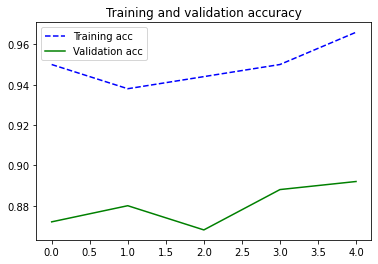

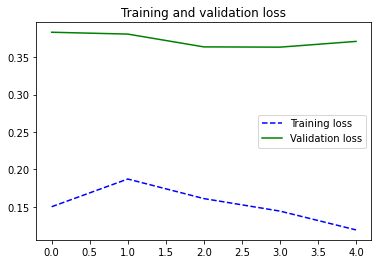

In [ ]:
plot_training_analysis()

loss: 49.52%
acc: 84.40%
Confusion matrix
[[20  0  2  1  1  1  0  0  0  0]
 [ 0 24  0  0  0  1  0  0  0  0]
 [ 0  0 23  0  1  1  0  0  0  0]
 [ 0  0  0 21  0  4  0  0  0  0]
 [ 3  0  0  0 16  3  0  2  0  1]
 [ 3  0  1  1  0 19  0  1  0  0]
 [ 3  0  0  0  1  0 20  1  0  0]
 [ 0  1  1  0  0  0  1 22  0  0]
 [ 0  1  1  0  0  0  0  0 23  0]
 [ 0  0  0  0  2  0  0  0  0 23]]
Pourcentage de precision de chaque classe:
[68.96551724137932, 92.3076923076923, 82.14285714285714, 91.30434782608695, 76.19047619047619, 65.51724137931035, 95.23809523809524, 84.61538461538461, 100.0, 95.83333333333333]


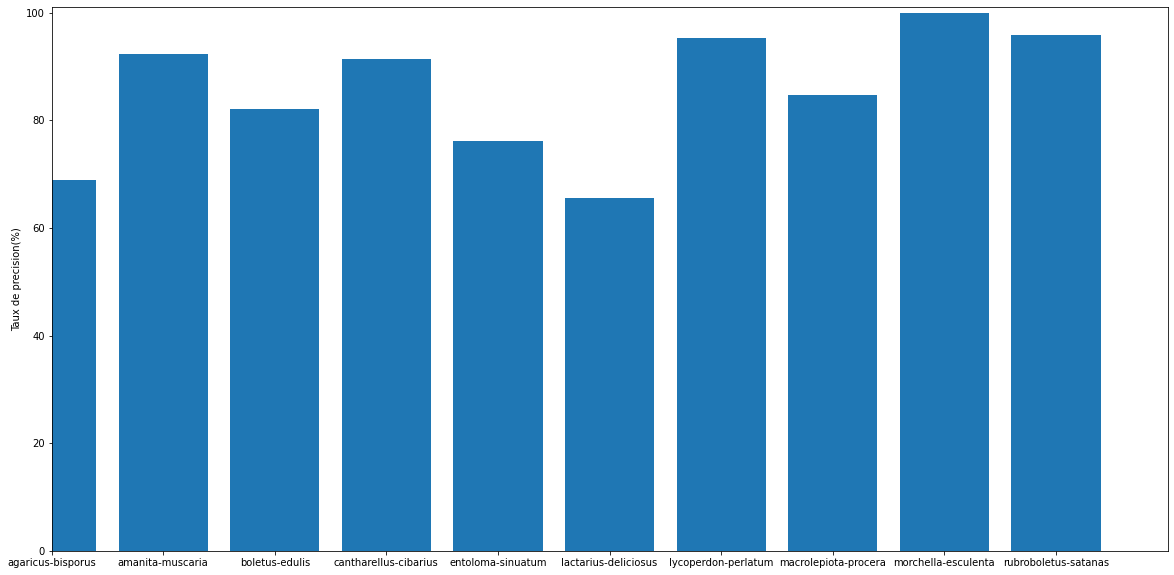

In [ ]:
pred=model.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
scores = model.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("Confusion matrix")
cm = confusion_matrix(test_generator.classes, predicted_class_indices)
print(cm)
precision=[]
for i in range(10):
  precision.append(100 * cm[i][i]/sum(cm[:,i]))

fig = plt.figure(1, figsize=(20, 10))
plt.bar(mushrooms_names, precision)
plt.axis([0, 10, 0, 101])
plt.ylabel('Taux de precision(%)')
print("Pourcentage de precision de chaque classe:")
print(precision)